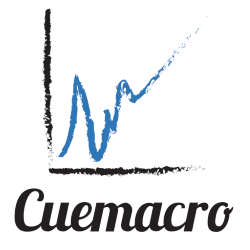

# A 10 minute view of tcapy

**Saeed Amen / Founder of Cuemacro**

https://www.cuemacro.com / saeed@cuemacro.com / @saeedamenfx / All material is copyright Cuemacro / 2020

Here we'll quickly introduce tcapy showing you how a few lines of code can quickly generate TCA to understand what you're trading costs are. Whilst tcapy supports the use of databases, caching or distributing computation (which we discuss in other notebooks), we'll focus on the basics here. You can also run this notebook interactively in [Binder](https://mybinder.org/v2/gh/cuemacro/tcapy/master?filepath=tcapy_notebooks/a_10_minute_view_of_tcapy.ipynb) to play around with the code.

## What is TCA?

Transaction cost analysis (TCA) involves looking at your trade/order data combined with market data to understand your trading costs. We can use TCA to calculate metrics like slippage and market impact, which we discuss later.

We should be able to understand how trading costs vary depending on upon factors like, asset, liquidity provider and method of execution (manual/algo).

## What is tcapy?

tcapy is one of the first open source Python libraries for doing TCA. Typically, developing a TCA library yourself could cost many hundreds of thousands of dollar. By contrast tcapy is free (of course sponsors for new features are always welcome, and Cuemacro also offers commercial support for tcapy).

## What's the difference between trades and orders?

We assume that an order has a start and end time, and hence a duration. It will have fields associated with it such as the
ticker traded, the execution price, the account, the execution trader, the broker, the algo used etc.
 
Underneath every order, there might be a number of trades and other events. The difference is that we assume these trade
events, are points in time. These trades will tag their respective orders.

## Benchmark

What should we consider as our benchmark? We need to have market data which is representative of the market as our reference point to compare our own trades. If we consider the FX spot market there are relatively small number of principal liquidity providers (LPs). At any one time, you might observe different skew in prices from different market makers, because of a number of reasons, such as different forecasts on where spot could go, their own inventory etc. Hence, using the mid of the pricing stream from a single market maker, it may not be representative of the market on aggregate. We are using the mid price as a proxy for the reference price.

We've focused on Dukascopy here, mainly because it's free, to allow readers to run this code (and so it works on Binder). However, you can try different data sources to see how it impacts your results.

At present tcapy has adapters to download market data from two data sources listed below to use as a benchmark. However, if you can feed whatever market data you want to the library and we hope to add more data sources in the future.
* Duksacopy - FX retail broker (free data) - note: doesn't have the past few weeks of data - our examples focus on this given it's free download
* New Change FX - data provider (paid data)

Once you've decided which market data to use, you can calculate several benchmarks, which are below. Some benchmarks like TWAP are only appropriate for orders, which have a start and finish time. The abstract class `Benchmark` in tcapy can be extended to create your own customised benchmarks.

* Mid price (`BenchmarkMarketMid`)
* TWAP (`BenchmarkTWAP`)
* VWAP (`BenchmarkVWAP`)

## Metrics

Metrics you might wish to calculate the below, and we've indicated the classes which implement these. In tcapy, there is the abstract `Metric` class, which can be extended so you can write your own metrics.

* slippage - the difference between your benchmark and the executed price (`MetricSlippage`)
* market impact - the price move following a trade/order (`MetricTransientMarketImpact` and `MetricPersistentMarketImpact`)

We haven't implemented this yet, but you might also want to look at some flat fees, which are charged depending on the trading venue (although these are much easier to keep track of, as you don't need any market data to calculate, just your trade data).

## Aggregated statistics

As part of TCA, we'd then want to generate statistics based on the metrics like those listed below. An abstract class `ResultsForm` aggregates various statistics. You can extend it to create your own aggregations.
* average (`BarResultsForm`)
* PDF (`DistResultsForm`)
* outlier (`TableResultsForm`)

## Doing the imports

Our first step is to add the tcapy library to our `PYTHONPATH`. You may need to change these lines. Note, that in our setup, we are running the Jupyter notebook on Windows, and the backend Celery workers on Linux. If you are running everything in the same environment, the paths are likely to be same. We'll also define some paths for the test data we'll use for trade/orders.

In [1]:
import sys
import os

windows_tcapy_path = 'e:/cuemacro/tcapy' # Windows platform
linux_tcapy_path = '/home/tcapyuser/cuemacro/tcapy' # Linux platform
local_test_data_path = '../test/resources/' # Windows platform
remote_test_data_path = '../test/resources/' # WSL drive

# Assuming the front end is on Windows
sys.path.insert(0, windows_tcapy_path)

If the Python path now includes tcapy, we can do all the imports from it, that we'll need later. We'll also import all the other Python libraries we'll use.

In [2]:
from collections import OrderedDict

# This is the entry point for our TCA analysis
from tcapy.analysis.tcaengine import TCAEngineImpl

# To construct the parameters for our TCA calculation
from tcapy.analysis.tcarequest import TCARequest

# To access trade and market data
from tcapy.data.databasesource import DatabaseSourceCSVBinary, \
    DatabaseSourceDataFrame, DatabaseSourceDukascopy

# Import all the metrics and benchmarks we'll use
from tcapy.analysis.algos.benchmark import BenchmarkArrival, BenchmarkMarketSpreadToMid
from tcapy.analysis.algos.metric import MetricSlippage, MetricTransientMarketImpact

# To aggregate the TCA results
from tcapy.analysis.algos.resultsform import TimelineResultsForm, DistResultsForm, BarResultsForm

# To help display the output of a TCA calculation
from tcapy.vis.tcaresults import TCAResults
from tcapy.vis.report.tcareport import TCAReport
from tcapy.vis.displaylisteners import PlotRender

# General classes
from tcapy.conf.constants import Constants
from tcapy.util.mediator import Mediator

# Prevent requests from displaying debug messages for certain libraries
import logging

logging.getLogger("findatapy").setLevel(logging.WARNING)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# For plotting later
import plotly.io as pio

# For interactive plots (but these disappear when we reopen Jupyter)
pio.renderers.default = "notebook" 

# For static plots, we use https://github.com/plotly/Kaleido
# pio.renderers.default = "svg"
pio.renderers.default = "png" 

import plotly

from chartpy import Chart, Style

# default size for Plotly charts we use
chart_width = 800
chart_height = 500

chart = Chart()
constants = Constants()
style = Style(width=chart_width, height=chart_height, scale_factor=-1, silent_display=True)

We can also set the market data source for use later, either downloading external data from Dukascopy or we can use some mocked up data in a Parquet file in the test folder.

In [3]:
market_data_store = 'dukascopy'
# market_data_store = os.path.join(local_test_data_path, 'small_test_market_df.parquet')

## Format of trade/order data for tcapy and DatabaseSource

tcapy has a test dataset of randomised trade/order data in CSV format, which we'll use later. We have generated these by taking market bid/ask data and then randomly perturbing the bid/ask for sells/buys respectively. Random sizes and directions have also been constructed. I'd suggest it's probably better to try using your own real trade data, as the output will be more 'realistic'. A lot of the output we'll get might end up looking artifical because of the simple assumptions we've made in the construction of the test data.

In [4]:
# The test trade/order data is populated between 25 Apr 2017-05 Jun 2017
# with trades/orders for 'EURUSD', 'USDJPY' and 'EURJPY'
csv_trade_order_mapping = {'trade_df' : os.path.join(local_test_data_path, 'small_test_trade_df.csv'),
                           'order_df' : os.path.join(local_test_data_path, 'small_test_order_df.csv')}

### Download data from Dukascopy

The `DatabaseSource` abstract class is extended to provide trade and market data access from internal sources (eg. CSV, Arctic/MongoDB), as well as external sources like Dukascopy. We demonsrate how to use `DatabaseSourceDukascopy` to download market data with quoted bid/ask from Dukascopy (we can't download trade data from that). If there are any timeouts in the external download, `findatapy` displays a warning, and will also retry the download.

In [5]:
%%time

database_source_dukascopy = DatabaseSourceDukascopy()

market_df = database_source_dukascopy.fetch_market_data(
    ticker='EURUSD', start_date='25 Apr 2017', finish_date='28 Apr 2017')

2020-07-27 12:18:39,244; DEBUG:tcapy.data.databasesource: Downloading 2017-04-25 00:00:00 - 2017-04-28 00:00:00 for EURUSD (databasesource.py:3819)


Wall time: 5.35 s


We can look at the market data downloaded to see the format.

In [6]:
market_df.head(10)

,bid,ask,mid,ticker
Date,,,,
2017-04-25 00:00:01.466000+00:00,1.08648,1.08654,1.086510,EURUSD
2017-04-25 00:00:01.618000+00:00,1.08650,1.08654,1.086520,EURUSD
2017-04-25 00:00:02.276000+00:00,1.08650,1.08654,1.086520,EURUSD
2017-04-25 00:00:04.081000+00:00,1.08649,1.08654,1.086515,EURUSD
2017-04-25 00:00:05.470000+00:00,1.08650,1.08654,1.086520,EURUSD
2017-04-25 00:00:06.039000+00:00,1.08650,1.08654,1.086520,EURUSD
2017-04-25 00:00:06.567000+00:00,1.08651,1.08654,1.086525,EURUSD
2017-04-25 00:00:07.604000+00:00,1.08652,1.08655,1.086535,EURUSD
2017-04-25 00:00:08.503000+00:00,1.08654,1.08656,1.086550,EURUSD


### Directly loading trade/order data from CSV

We can use `DatabaseSourceCSVBinary` to open up the trade and order data.

In [7]:
trade_df = DatabaseSourceCSVBinary(trade_data_database_csv=csv_trade_order_mapping['trade_df']) \
    .fetch_trade_order_data()

order_df = DatabaseSourceCSVBinary(trade_data_database_csv=csv_trade_order_mapping['order_df']) \
    .fetch_trade_order_data()

### Exploring trade/order data

Let's look at the trade data so we can understand the type of format that tcapy needs. We can see that each trade is a point in time. In some cases, these are actual `trade` events, other times they are `placement`, `cancel` or `cancel/replace` messages. The times of two different events can be identical, and there are some instances of this in the test datasets of trade/orders. Note, that this can often cause problems with Pandas, so if do create your own `Metric` and `Benchmark` variations, do check that your implementations can manage it (can require some rewriting of the code).

In [8]:
trade_df.head(5)

,account_id,algo_id,algo_settings,ancestor_pointer_id,broker_id,broker_sub_id,event_type,executed_notional,executed_price,id,...,market_mid,notional_currency,order_notional,portfolio_id,portfolio_manager_id,price_limit,side,ticker,trader_id,venue
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-25 07:09:31.804000+00:00,account3,algo4,default,order_EURUSD2017-04-25 07:09:31.804000+00:00_2...,broker5,subbroker1,placement,0,0.000000,execution_EURUSD2017-04-25 07:09:31.804000+00:...,...,1.087965,EUR,18517881,portfolio4,pm2,1.087965,-1,EURUSD,trader1,venue4
2017-04-25 07:09:33.765000+00:00,account3,algo4,default,order_EURUSD2017-04-25 07:09:31.804000+00:00_2...,broker5,subbroker1,trade,18517881,1.087965,execution_EURUSD2017-04-25 07:09:33.765000+00:...,...,1.087990,EUR,18517881,portfolio4,pm2,1.087965,-1,EURUSD,trader1,venue3
2017-04-25 11:09:52.384000+00:00,account3,algo6,default,order_EURUSD2017-04-25 11:09:52.384000+00:00_2...,broker6,subbroker6,placement,0,0.000000,execution_EURUSD2017-04-25 11:09:52.384000+00:...,...,1.088090,EUR,8364696,portfolio4,pm3,1.088090,-1,EURUSD,trader5,venue4
2017-04-25 11:09:53.242000+00:00,account3,algo6,default,order_EURUSD2017-04-25 11:09:52.384000+00:00_2...,broker6,subbroker6,cancel/replace,0,0.000000,execution_EURUSD2017-04-25 11:09:53.242000+00:...,...,1.088080,EUR,0,portfolio4,pm3,1.088090,-1,EURUSD,trader5,venue3
2017-04-25 11:10:20.251000+00:00,account3,algo6,default,order_EURUSD2017-04-25 11:09:52.384000+00:00_2...,broker6,subbroker6,trade,8364696,1.088093,execution_EURUSD2017-04-25 11:10:20.251000+00:...,...,1.088125,EUR,8364696,portfolio4,pm3,1.088090,-1,EURUSD,trader5,venue4


Let's print out all the fields. Some fields are compulsory for use in tcapy, including the index (`Date`), `ticker`, `side` etc. Some fields here are optional such as `market_ask`, `market_bid` and `market_mid`. Similar fields will be autogenerated from the market data and appends to the trade data. `DatabaseSource` does minimal changes to the format of the data. Each of these trade message point to the order which they belong to. There can be multiple trade messages within a single order.

In [9]:
trade_df.columns

Index(['account_id', 'algo_id', 'algo_settings', 'ancestor_pointer_id',
       'broker_id', 'broker_sub_id', 'event_type', 'executed_notional',
       'executed_price', 'id', 'market_ask', 'market_bid', 'market_mid',
       'notional_currency', 'order_notional', 'portfolio_id',
       'portfolio_manager_id', 'price_limit', 'side', 'ticker', 'trader_id',
       'venue'],
      dtype='object')

If we look at the order data, one the key differences, which we noted is that each order has a `benchmark_date_start` and `benchmark_date_end`, a start and end time. Note, obviously this randomized data. We also see that it doesn't have columns for `executed_notional` data or `executed_price` data. tcapy can generate this from the underlying trade fills from the earlier table.

In [10]:
order_df.head(5)

,account_id,algo_id,algo_settings,arrival_price,benchmark_date_end,benchmark_date_start,broker_id,broker_sub_id,id,notional,notional_currency,portfolio_id,portfolio_manager_id,price_limit,side,ticker,trader_id
Date,,,,,,,,,,,,,,,,,
2017-04-25 07:09:31.804000+00:00,account3,algo4,default,1.087965,2017-04-25 10:40:16.512000+00:00,2017-04-25 07:09:31.804000+00:00,broker5,subbroker1,order_EURUSD2017-04-25 07:09:31.804000+00:00_2...,18517881,EUR,portfolio4,pm2,1.087965,-1,EURUSD,trader1
2017-04-25 11:09:52.384000+00:00,account3,algo6,default,1.088090,2017-04-25 14:33:06.745000+00:00,2017-04-25 11:09:52.384000+00:00,broker6,subbroker6,order_EURUSD2017-04-25 11:09:52.384000+00:00_2...,8364696,EUR,portfolio4,pm3,1.088090,-1,EURUSD,trader5
2017-04-25 15:50:41.479000+00:00,account1,algo3,default,1.093765,2017-04-26 06:01:27.935000+00:00,2017-04-25 15:50:41.479000+00:00,broker5,subbroker5,order_EURUSD2017-04-25 15:50:41.479000+00:00_2...,774423,EUR,portfolio1,pm6,1.093765,-1,EURUSD,trader3
2017-04-26 06:48:48.562000+00:00,account4,algo2,default,1.092460,2017-04-26 09:57:57.631000+00:00,2017-04-26 06:48:48.562000+00:00,broker3,subbroker3,order_EURUSD2017-04-26 06:48:48.562000+00:00_2...,16465763,EUR,portfolio3,pm5,1.092460,-1,EURUSD,trader5
2017-04-26 11:15:50.864000+00:00,account6,algo1,default,1.089585,2017-04-26 14:41:01.382000+00:00,2017-04-26 11:15:50.864000+00:00,broker3,subbroker6,order_EURUSD2017-04-26 11:15:50.864000+00:00_2...,11501881,EUR,portfolio4,pm3,1.089585,-1,EURUSD,trader4


tcapy can do TCA on trade data on its own (or trade and order data together). Make sure that your trade/order is in a similar format to use with tcapy.

## TCA computations

We earlier created a trade/order mapping, to tell tcapy where to find the trade/order data, which is this case is in CSV files. Note the use of `trade_df` and `order_df`, which you'll have to use each time. We create a `TCAEngineImpl` object which will be used to accept a `TCARequest` for doing the TCA computation. We also get reference to the `VolatileCache` which uses Redis underneath (if Redis isn't installed, calculations will proceed, it'll just be slower).

In [11]:
tca_version  = constants.tcapy_version
tca_engine = TCAEngineImpl(version=tca_version)

2020-07-27 12:18:44,704; INFO:tcapy.analysis.tcaengine: Init TCAEngine version: pro - Env: desktop_laptop_linux (tcaengine.py:53)


We create a `TCARequest`, which will be run on our trade/order CSV files. It allows us to specify our `TCARequest` in a Pythonic like way, as opposed to using some sort of query language directly (like SQL or q). Obviously, the key advantage of this is because tcapy supports all sorts of databases, we don't need to change our `TCARequest` much if we change our underlying data sources.

The market data will be externally downloaded from Dukascopy. In this instance, we have set `use_multithreading=False` which avoids the use of Celery, and makes it easier to run on Binder. We can add the below, for calculation:

* `Metric` to measure the "quality" of each trade/order
    * We've added `MetricSlippage` which by default calcualtes the difference between the `mid` price and the `executed_price`
* `Benchmark` to capture what the market is around each trade/order
    * We've added `BenchmarkArrival` which will the mid price for the arrival price of every trade/order
* `ResultForm` objects to aggregate the statistics of various fields. 
    * We've added `TimelineResultsForm` will calculate the average `slippage` by day and hour. We use a `scalar` of `10000.0` to convert the values into basis points, which are easier to interpret
    * By default the slippage will be weighted by the `executed_notional` although we can change the weighting field
    
Whilst we are asking for ticker `EURUSD`, tcapy will also search for trades/orders booked the "wrong" way round ie. `USDEUR` and normalize them so they are converted to `EURUSD` trades/orders.

In [12]:
# We are conducting a TCA computation for trade/order data between 05 May-10 May 2017 for EURUSD
# The trade dataset is from CSV and the market data is downloaded from Dukascopy/or a mocked up file
# For metrics, we are calculating slippage and for benchmarks we are adding a field for the arrival price
# We are creating a timeline of average slippage by date and hour
tca_request = TCARequest(start_date='05 May 2017', finish_date='10 May 2017', ticker=['EURUSD'],
                         tca_type='detailed',
                         trade_data_store='csv', market_data_store=market_data_store,
                         trade_order_mapping=csv_trade_order_mapping,
                         metric_calcs=[MetricSlippage()],
                         results_form=[TimelineResultsForm(metric_name='slippage', 
                                                           by_date='datehour', scalar=10000.0)],
                         benchmark_calcs=[BenchmarkArrival(), 
                                          BenchmarkMarketSpreadToMid()],
                         use_multithreading=False)

Notice there a lot of the log output can be suppressed if we change the logging level to `INFO` in `constants.py`.

`calculate_tca` will use several other classes. We describe the rough steps of the calculation before:
* `TCAMarketTradeLoaderImpl` manages the computation
* A different instance of `TCATickerLoaderImpl` for each ticker will then
    * load the market, trade and order data (using `DataFactory`, `DatabaseSource` etc.)
    * calculate all the metrics and benchmarks (using `Metric`, `Benchmark` etc.)
* `TCAMarketTradeLoaderImpl` will then aggregate the statistics generated (using `ResultsForm`)
* dictonary of (mostly) `DataFrame` objects returned to the caller by `calculate_tca`

As we noted before if there are any timeouts in downloading the data, it will attempt to retry a few times. **This may take several minutes, if are downloading a lot of data over the web. You might get some warning messages because it is trying to access a cache, which may not exist on Binder, which will also slow down the computation.**

In [13]:
# Dictionary of (mostly) dataframes as output from TCA calculation
dict_of_df = tca_engine.calculate_tca(tca_request)

2020-07-27 12:18:44,724; DEBUG:tcapy.analysis.tcamarkettradeloader: Start loading trade/data/computation (tcamarkettradeloader.py:241)
2020-07-27 12:18:44,728; DEBUG:tcapy.analysis.tcatickerloaderimpl: Get market and trade/order data for EURUSD from 2017-05-05 00:00:00+00:00 - 2017-05-10 00:00:00+00:00 (tcatickerloaderimpl.py:80)
2020-07-27 12:18:44,730; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['dukascopy_EURUSD_2017-05-05 00:00:00+00:00_2017-05-10 00:00:00+00:00_market_df_None_comp'] (volatilecache.py:540)
2020-07-27 12:18:44,800; DEBUG:tcapy.analysis.tcatickerloader: Get trade order holder for EURUSD from 2017-05-05 00:00:00+00:00 - 2017-05-10 00:00:00+00:00 (tcatickerloader.py:386)
2020-07-27 12:18:44,849; WARNING:tcapy.data.datafactory: Dataframe empty for ticker USDEUR (datafactory.py:97)
2020-07-27 12:18:44,851; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['dukascopy_EURUSD_2017-05-05 00:00:00+00:00_2017-05-10 00:00:00+00:00_marke

### Interpreting the TCA computation output

Let's take a look at the dictionary returned.

In [14]:
dict_of_df.keys()

odict_keys(['trade_df', 'order_df', 'sparse_market_trade_df', 'sparse_market_order_df', 'market_df_downsampled', 'candlestick_fig', 'timeline_trade_df_slippage_by/mean_datehour/all', 'timeline_order_df_slippage_by/mean_datehour/all', 'market_df'])

We explain what each item in the dictionary is below:

* for further analysis
    * `trade_df` - DataFrame of trades (with added calculated fields like slippage, arrival price etc.)
    * `order_df` - DataFrame of orders (with added calculated fields like slippage, arrival price etc.)
* for plotting
    * `sparse_market_trade_df` - DataFrame with market data and trades
    * `sparse_market_order_df` - DataFrame with market data and orders
    * `market_df_downsampled` - DataFrame with downsampled market data
    * `candlestick_fig` - Plotly JSON of the market data as candlesticks
* aggregated data
    * `timeline_trade_df_slippage_by/mean_date/all` - a timeline of the slippage for the trades
    * `timeline_order_df_slippage_by/mean_date/all` - a timeline of the slippage for the orders

We can plot the timeline of the slippage by day and hour. During this period the slippage has been between 0.3 and 0.05 basis points (bp), which seems reasonable for EUR/USD.

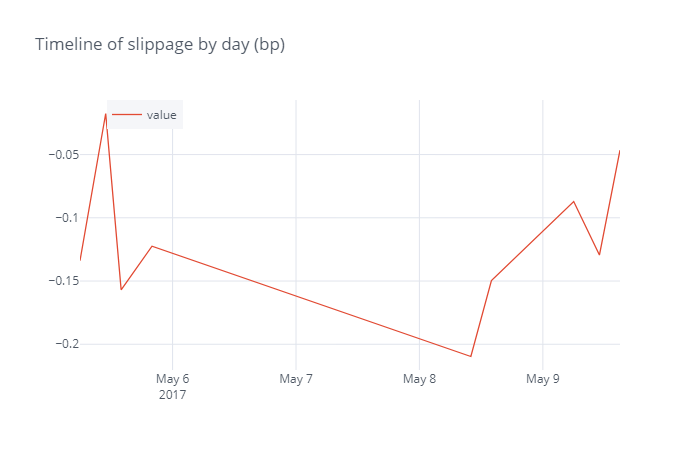

In [15]:
style.title = 'Timeline of slippage by day (bp)'
chart.plot(dict_of_df['timeline_trade_df_slippage_by/mean_datehour/all'], engine='plotly', style=style)

### Explaining output of tcapy calculation in trade/order DataFrames

Let's also take a look at the returned `trade_df` DataFrame. Most of the fields are the same, but there now additional fields fields calculated by tcapy. Note, these will vary depending on which `Metric` and `Benchmark` objects you specify in the `TCARequest`:
* `arrival` - arrival price from the benchmark at time of the order/just before
* `slippage_benchmark` - difference between mid price from the market data, just before/at trade
* `spread_to_benchmark` - differnce to the bid (for sells) and to the ask (for buys) - if this data is available
* `slippage` - difference between `executed_price` and benchmark
* `slippage_anomalous` - 1 if the slippage is beyond a certain 

We also have fields for the notional in reporting currency (here `USD`) which are autogenerated from the market data combined with the trade data. You can specify you own reporting currency in `Constants`. It is useful to have this field, if you want to calculate total trading costs across many different currency pairs later.

### Using TCAResults class

We can use a higher level `TCAResults` object to simplify the output of the TCA calculation. Here we create the Plotly JSON for all the charts which have been requested.

In [16]:
tca_results = TCAResults(dict_of_df, tca_request, chart_width=chart_width, chart_height=chart_height)
tca_results.render_computation_charts()

2020-07-27 12:18:57,916; DEBUG:tcapy.vis.displaylisteners: Plotting main timeline 2583 (displaylisteners.py:988)
2020-07-27 12:18:57,974; DEBUG:tcapy.vis.displaylisteners: Rendered plot 2583 and  (displaylisteners.py:998)
2020-07-27 12:18:57,977; DEBUG:tcapy.vis.displaylisteners: Plotting main timeline 2576 (displaylisteners.py:988)
2020-07-27 12:18:58,035; DEBUG:tcapy.vis.displaylisteners: Rendered plot 2576 and  (displaylisteners.py:998)


Let's get the trade data from the `TCAResults` objects.

In [17]:
tca_results.trade_order['trade_df'].head(5)

,account_id,algo_id,algo_settings,ancestor_pointer_id,broker_id,broker_sub_id,event_type,executed_notional,executed_price,id,...,notional_reporting_currency_mid,reporting_currency,executed_notional_in_reporting_currency,order_notional_in_reporting_currency,notional,arrival,slippage_benchmark,spread_to_benchmark,slippage,slippage_anomalous
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-05 06:27:26.514000+00:00,account5,algo2,default,order_EURUSD2017-05-05 06:26:47.189000+00:00_2...,broker6,subbroker1,trade,18008368,1.097430,execution_EURUSD2017-05-05 06:27:26.514000+00:...,...,1.097445,USD,1.976319e+07,1.976319e+07,18008368,1.097445,1.097445,-0.000005,-0.000013,1
2017-05-05 11:30:00.791000+00:00,account5,algo3,default,order_EURUSD2017-05-05 11:28:43.816000+00:00_2...,broker3,subbroker3,trade,5370024,1.095723,execution_EURUSD2017-05-05 11:30:00.791000+00:...,...,1.095725,USD,5.884070e+06,5.884070e+06,5370024,1.095725,1.095725,-0.000014,-0.000002,0
2017-05-05 14:56:49.373000+00:00,account4,algo2,default,order_EURUSD2017-05-05 14:56:33.125000+00:00_2...,broker2,subbroker5,trade,6198753,1.098892,execution_EURUSD2017-05-05 14:56:49.373000+00:...,...,1.098875,USD,6.811655e+06,6.811655e+06,6198753,1.098875,1.098875,-0.000014,-0.000016,1
2017-05-05 20:33:21.932000+00:00,account6,algo2,default,order_EURUSD2017-05-05 20:33:14.677000+00:00_2...,broker5,subbroker6,trade,6270424,1.099439,execution_EURUSD2017-05-05 20:33:21.932000+00:...,...,1.099425,USD,6.893861e+06,6.893861e+06,6270424,1.099425,1.099425,-0.000023,-0.000012,0
2017-05-08 10:31:33.011000+00:00,account1,algo3,default,order_EURUSD2017-05-08 10:30:57.526000+00:00_2...,broker4,subbroker2,trade,3276653,1.094703,execution_EURUSD2017-05-08 10:31:33.011000+00:...,...,1.094680,USD,3.586887e+06,3.586887e+06,3276653,1.094680,1.094680,-0.000009,-0.000021,1


We can access the timeline of the slippage for trades by accessing the `timeline` property. Note, it won't be populated for date/hours where we haven't traded.

In [18]:
tca_results.timeline['trade_df_slippage_by/mean_datehour/all'].head(5)

,value
Date,
2017-05-05 06:00:00,-0.133895
2017-05-05 11:00:00,-0.017519
2017-05-05 14:00:00,-0.156906
2017-05-05 20:00:00,-0.122419
2017-05-08 10:00:00,-0.209665


### Distribution of slippage and average slippage

Here we create a `TCARequest` for the same dataset. This time, however, we also calculate the `MetricTransientMarketImpact`, which we've defined as the 5 second move from a trade or start of an order. We also want to calculate the distribution of the slippage by side (ie. buy/sell) with `DistResultsForm` and to calculate the average slippage (weighted by the executed notional) with `BarResultForm`. Note, we've used `scalar` parameters of `10000.0` to convert to basis point to ease understanding.

All these `Metric` and `ResultsForm` calculations will be calculated on both trades and orders. However, we can specify for it to be calculated only on for example trades, by instantiating the objects using the `market_trade_order_list` parameter eg. `MetricSlippage(market_trade_order_list=['trade_df'])`

In [19]:
tca_request = TCARequest(start_date='05 May 2017', finish_date='20 May 2017', ticker='EURUSD',
    tca_type='detailed',
    trade_data_store='csv', market_data_store=market_data_store,
    trade_order_mapping=csv_trade_order_mapping,
    metric_calcs=[MetricSlippage(), 
        MetricTransientMarketImpact(
                             transient_market_impact_gap={'5' : 's'})],
    results_form=[DistResultsForm(metric_name='slippage', 
                  aggregate_by_field='side', scalar=10000.0),
        BarResultsForm(metric_name='slippage', 
            aggregate_by_field='ticker', scalar=10000.0),
        BarResultsForm(metric_name='slippage', 
            aggregate_by_field='broker_id', scalar=10000.0)],
    benchmark_calcs=[BenchmarkMarketSpreadToMid()],
    use_multithreading=False)

Let's kick off the TCA calculation! **Again this can take several minutes to download the data. You might get some warning messages because it is trying to access a cache**.

In [20]:
%%time

# Dictionary of (mostly) dataframes as output from TCA calculation
dict_of_df = tca_engine.calculate_tca(tca_request)

2020-07-27 12:18:58,094; INFO:tcapy.analysis.tcaengine: More than 1 ticker specified for TCA detailed computation. Only working on first (tcaengine.py:122)
2020-07-27 12:18:58,095; DEBUG:tcapy.analysis.tcamarkettradeloader: Start loading trade/data/computation (tcamarkettradeloader.py:241)
2020-07-27 12:18:58,096; DEBUG:tcapy.analysis.tcatickerloaderimpl: Get market and trade/order data for EURUSD from 2017-05-05 00:00:00+00:00 - 2017-05-20 00:00:00+00:00 (tcatickerloaderimpl.py:80)
2020-07-27 12:18:58,097; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['dukascopy_EURUSD_2017-05-05 00:00:00+00:00_2017-05-20 00:00:00+00:00_market_df_None_comp'] (volatilecache.py:540)
2020-07-27 12:18:58,323; DEBUG:tcapy.analysis.tcatickerloader: Get trade order holder for EURUSD from 2017-05-05 00:00:00+00:00 - 2017-05-20 00:00:00+00:00 (tcatickerloader.py:386)
2020-07-27 12:18:58,386; DEBUG:tcapy.data.volatilecache: Attempting to get list from cache: ['dukascopy_USDEUR_2017-05-05 0

Wall time: 1.87 s


Let's inspect the output. This time we have some different DataFrames, in particular:
* `dist_trade_df_slippage_by/pdf/side` - distribution of slippage on trades split up by buy/sell
* `bar_trade_df_slippage_by/mean/ticker` - average of slippage on trades split by ticker
* `bar_trade_df_slippage_by/mean/broker_id` - average of slippage on trades split by broker
* `dist_order_df_slippage_by/pdf/side` - distribution of slippage on orders split up by buy/sell
* `bar_order_df_slippage_by/mean/ticker` - average of slippage on trades split by ticker
* `bar_order_df_slippage_by/mean/broker_id` - average of slippage on trades split by broker

In [21]:
dict_of_df.keys()

odict_keys(['trade_df', 'order_df', 'sparse_market_trade_df', 'sparse_market_order_df', 'market_df_downsampled', 'candlestick_fig', 'dist_trade_df_slippage_by/pdf/side', 'bar_trade_df_slippage_by/mean/ticker', 'bar_trade_df_slippage_by/mean/broker_id', 'dist_order_df_slippage_by/pdf/side', 'bar_order_df_slippage_by/mean/ticker', 'bar_order_df_slippage_by/mean/broker_id', 'market_df'])

We can use  the `PlotRender` object (which is used by the GUI) to create different sorts of Ploty charts such as the timelines, distributions etc. In this case we are plotting the distribution of the slippage by buy/sell. Note that if we'd used the `TCAResults` object instead it would have simplified this code.

2020-07-27 12:18:59,987; DEBUG:tcapy.vis.displaylisteners: Plotting distribution dist (displaylisteners.py:1239)
2020-07-27 12:19:00,005; DEBUG:tcapy.vis.displaylisteners: Rendered distribution dist (displaylisteners.py:1243)


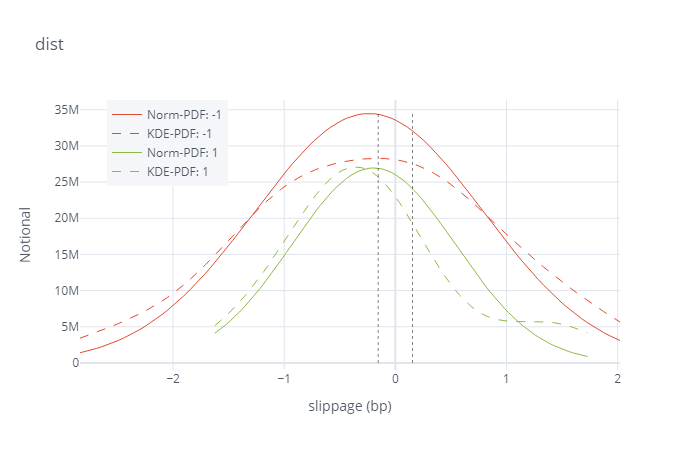

In [22]:
plot_render = PlotRender()

# Generate Plotly JSON Figure
dist_fig = plot_render.plot_dist(dist_df=dict_of_df['dist_order_df_slippage_by/pdf/side'], 
          metric='slippage', split_by='side', width=chart_width, height=chart_height)
   
# Render the Plotly JSON Figure to view
chart.plot(dist_fig, engine='plotly', style=style)

Alternatively, we can push the output into a `TCAResults` object, which can simplify the TCA output, in a much easier to use way. We can see that several charts end up getting rendered, such as timeline and distribution plots, together with more descriptive titles. We do not need to get into the low level details of how to do the plotting with Plotly, tcapy does that all for us using chartpy. However, if we want we can of course edit the returned `Plotly Figure` object (see here on do [this](https://plotly.com/python/creating-and-updating-figures)).

In [23]:
tca_results = TCAResults(dict_of_df, tca_request, chart_width=chart_width, chart_height=chart_height)
tca_results.render_computation_charts()

2020-07-27 12:19:00,147; DEBUG:tcapy.vis.displaylisteners: Plotting main timeline 2352 (displaylisteners.py:988)
2020-07-27 12:19:00,206; DEBUG:tcapy.vis.displaylisteners: Rendered plot 2352 and  (displaylisteners.py:998)
2020-07-27 12:19:00,210; DEBUG:tcapy.vis.displaylisteners: Plotting main timeline 2346 (displaylisteners.py:988)
2020-07-27 12:19:00,272; DEBUG:tcapy.vis.displaylisteners: Rendered plot 2346 and  (displaylisteners.py:998)
2020-07-27 12:19:00,317; DEBUG:tcapy.vis.displaylisteners: Plotting distribution Trades slippage by/pdf/side PDF (displaylisteners.py:1239)
2020-07-27 12:19:00,334; DEBUG:tcapy.vis.displaylisteners: Rendered distribution Trades slippage by/pdf/side PDF (displaylisteners.py:1243)
2020-07-27 12:19:00,339; DEBUG:tcapy.vis.displaylisteners: Plotting distribution Orders slippage by/pdf/side PDF (displaylisteners.py:1239)
2020-07-27 12:19:00,363; DEBUG:tcapy.vis.displaylisteners: Rendered distribution Orders slippage by/pdf/side PDF (displaylisteners.py:12

We can pickup the Plotly JSON `Figure` object ready made to push to `chartpy` for plotting.

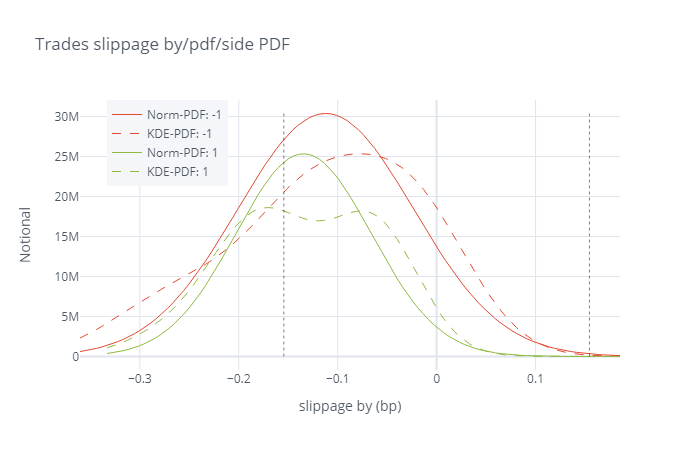

In [24]:
chart.plot(tca_results.dist_charts['trade_df_slippage_by/pdf/side'], engine='plotly', style=style)

Depending on what we have specified to be calculated in the `TCARequest` the `TCAReport` can render the following charts (which are available as attributes

* `timeline_charts` - timeline aggregates
* `sparse_market_charts` - mixture of market data with points to denote trades/orders
* `bar_charts` - average aggregates eg. average slippage
* `dist_charts` - distribution charts eg. distribution of slippage
* `scatter_charts` - scatter charts eg. plotting slippage vs. notional
* `styled_tables` - tables in HTML format

We can also get the underlying DataFrames using the following properties

* `trade_order` - DataFrames of trades/orders
* `timeline` - DataFrames of timelines
* `sparse_market` - DataFrames with a mixture of market data/trade/order data
* `bar` - DataFrames with bar chart style data
* `dist` - DataFrames with distribution style data
* `scatter` - DataFrames with scatter style data
* `table` - DataFrames intended to be displayed as tables
* `market` - DataFrames with high frequency tick market data

Let's see inside the `dist_charts` and `bar_charts` to see keys are available.

In [25]:
print(tca_results.dist_charts.keys())
print(tca_results.bar_charts.keys())

dict_keys(['trade_df_slippage_by/pdf/side', 'order_df_slippage_by/pdf/side'])
dict_keys(['trade_df_slippage_by/mean/ticker', 'trade_df_slippage_by/mean/broker_id', 'order_df_slippage_by/mean/ticker', 'order_df_slippage_by/mean/broker_id'])


Plot the average slippage by ticker! In this case, we only have one ticker, so probably just easier to report the number itself, which arount 0.5 bp.

                ticker
ticker_index          
EURUSD       -0.217804


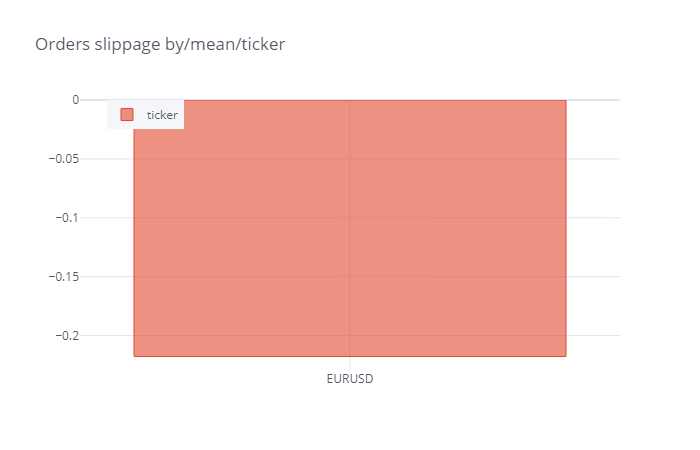

In [26]:
print(tca_results.bar['order_df_slippage_by/mean/ticker'])

chart.plot(tca_results.bar_charts['order_df_slippage_by/mean/ticker'], 
           engine='plotly', style=style)

Plot the average slippage by broker. Looks like `broker4` hasn't been particularly good!

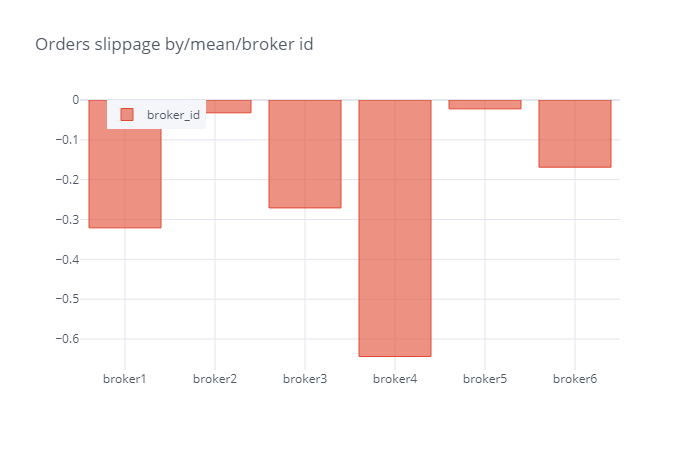

In [27]:
chart.plot(tca_results.bar_charts['order_df_slippage_by/mean/broker_id'], engine='plotly', style=style)

We can plot one of the PDF charts too.

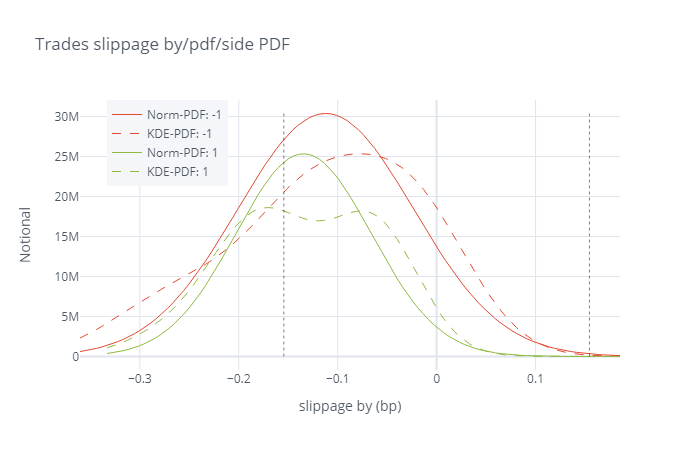

In [28]:
chart.plot(tca_results.dist_charts['trade_df_slippage_by/pdf/side'], 
           engine='plotly', style=style)

Let's try seeing what the `sparse_market_chart` property looks like.

In [29]:
print(tca_results.sparse_market_charts.keys())

dict_keys(['EURUSD_trade_df', 'EURUSD_order_df'])


We plot the market data benchmark alongside the trades as dots, sized by their executed notional and with different colors for buy (green) and sell (red).

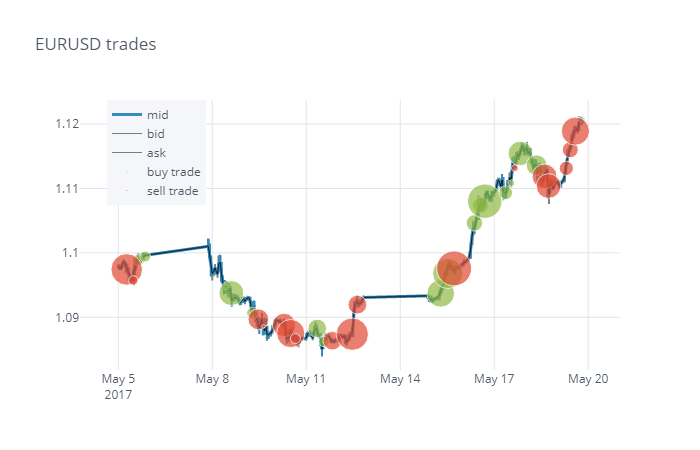

In [30]:
chart.plot(tca_results.sparse_market_charts['EURUSD_trade_df'], engine='plotly', style=style)

Because these charts are already Plotly Figure objects in JSON, we can also display them directly, without the `Chart` object.

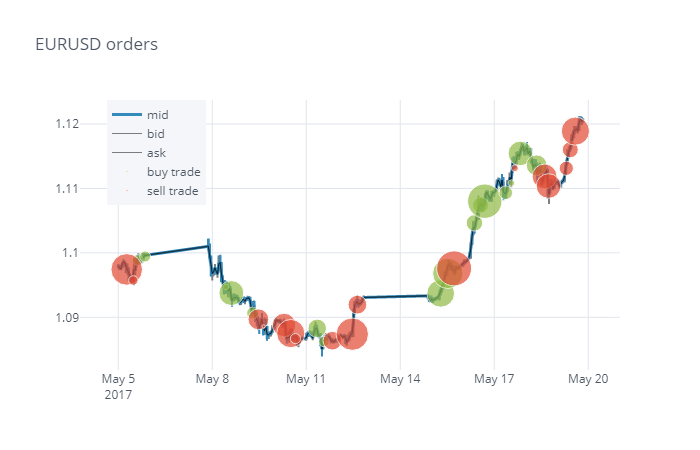

In [31]:
tca_results.sparse_market_charts['EURUSD_order_df']

If we print the charts, we can see inside the Plotly Figure JSON format.

In [32]:
print(tca_results.sparse_market_charts['EURUSD_trade_df'])

Figure({
    'data': [{'connectgaps': True,
              'line': {'color': 'rgba(0.20392156862745098, 0.5411764705882353, 0.7411764705882353, 1.0)',
                       'dash': 'solid',
                       'width': 3},
              'mode': 'lines',
              'name': 'mid',
              'text': '',
              'type': 'scatter',
              'x': [2017-05-05 00:00:00+00:00, 2017-05-05 01:00:00+00:00,
                    2017-05-05 02:00:00+00:00, ..., 2017-05-19
                    18:19:18.110000+00:00, 2017-05-19 19:00:00+00:00, 2017-05-19
                    20:00:00+00:00],
              'y': array([1.0979177951812744, 1.0976229906082153, 1.0974935293197632, ..., '',
                          1.1204367876052856, 1.1205419301986694], dtype=object)},
             {'connectgaps': True,
              'line': {'color': 'rgba(0.0, 0.0, 0.0, 1.0)', 'dash': 'solid', 'width': 0.5},
              'mode': 'lines',
              'name': 'bid',
              'text': '',
         

We can update the properties of a Plotly figure too, such as the title, without having to redraw the whole chart.

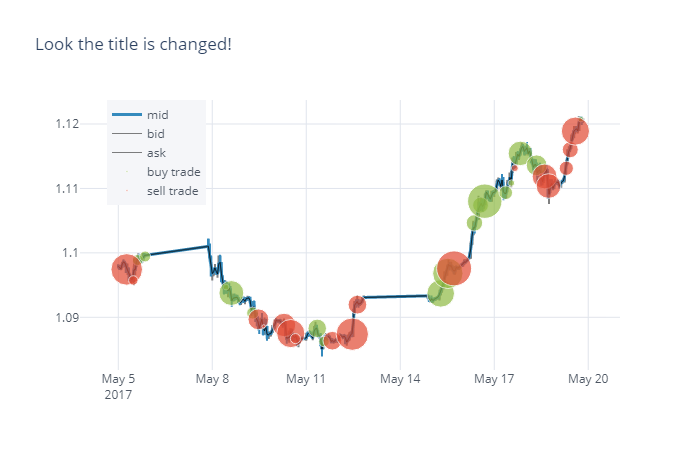

In [33]:
trade_fig = tca_results.sparse_market_charts['EURUSD_trade_df']
trade_fig.update_layout(title='Look the title is changed!')

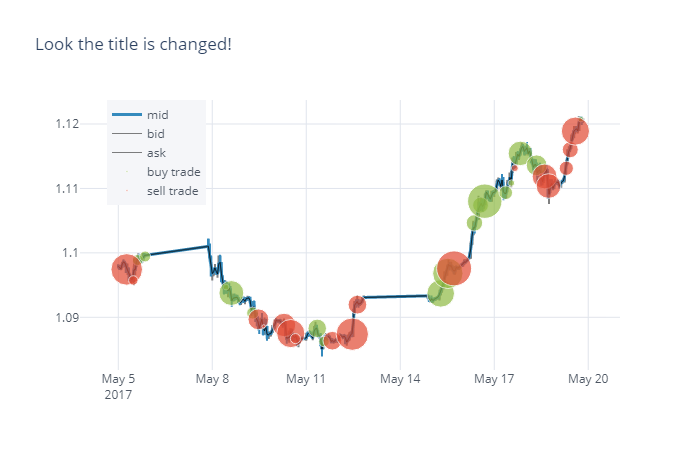

In [34]:
trade_fig

# Conclusion

We've seen a quick 10 minute view of tcapy, with some examples of how to call the library. We've also done many other notebooks, showing some of the more advanced functionality of tcapy, which you can look at next. If you are interesting supporting this project, please contact saeed@cuemacro.com.